# Datetime String Parsing/Formatting
## Research Questions
**What are the most common string formats used for datetimes?**
 * What are the most common formats for certain usecases? (logging, external storage, UI)

**How often do people follow standards vs. use their own formats?**
 * iso format compliance
 * builtin methods vs custom formats

**How often do people use format agnostic parsers?**
 * How often are there bugs related to unclear date formats?
 * These are hard to detect because most of them are just named "parse"

**How consistent are people with formats within a single project?**
 * How many calls do people make to parse/format methods per project
 * How many formats are used within strftime and strptime in each project

**How much intention are people putting into their formats?**
 * Not quantifiable at all
 * strftime vs builtins
 * "least resistance methods" like `str()` or format strings.
 
## Issues with the current scripts
 * Hard to detect `from a import b; b()`. Most `parse` methods fall under this category.
 * Not currently distinguishing between `time.strftime` and `datetime.strftime`.
 * Can't properly handle multiline calls.
 * Can't properly handle format constants e.g. `FORMAT = '%Y%m%d'; dt.strftime(FORMAT)`.
 * False positives on comments mentioning method names.
 * Doesn't detect str() or format strings

In [1]:
%pip install pandas
%pip install numpy
# %pip install seaborn

import pandas as pd
import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import re


# Read the data from the TSV file
# STRING_OPS_PATH = '/data/petervan/date-time/data/string_operations.csv'
STRING_OPS_PATH = 'string_operations.csv'
df = pd.read_csv(STRING_OPS_PATH)
print(len(df))
df

# df[["owner", "repo", "path", "line", "operation", "text"]].to_csv(STRING_OPS_PATH, index=False)

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
136074


,owner,repo,path,line,operation,pattern,text
0,mkdocs,mkdocs,mkdocs:mkdocs/mkdocs/utils/__init__.py,83,format,strftime,return get_build_datetime().strftime('%Y-%...
1,mkdocs,mkdocs,mkdocs:mkdocs/mkdocs/livereload/__init__.py,79,format,strftime,"return time.strftime(""[%H:%M:%S] "") + ..."
2,prompt-toolkit,python-prompt-toolkit,docs/conf.py,62,format,strftime,"# Else, today_fmt is used as the format for a ..."
3,prompt-toolkit,python-prompt-toolkit,docs/conf.py,179,format,strftime,# using the given strftime format.
4,prompt-toolkit,python-prompt-toolkit,examples/full-screen/text-editor.py,231,format,isoformat,text = datetime.datetime.now().isoformat()
...,...,...,...,...,...,...,...
136069,togethercomputer,MoA,FastChat/fastchat/serve/monitor/dataset_releas...,66,format,strftime,"datetime.datetime.fromtimestamp(x, tz=time..."
136070,jishengpeng,ControlSpeech,baseline/promptTTS/utils/commons/trainer.py,545,format,strftime,t = datetime.now().strftime('%Y%m%d%H%...
136071,jishengpeng,ControlSpeech,baseline/promptTTS/utils/commons/trainer.py,551,format,strftime,t = datetime.now().strftime('%Y%m%...
136072,jishengpeng,ControlSpeech,baseline/promptTTS/mfa_usr/mfa.py,477,format,strftime,execution_time = time....


In [2]:
def get_even_colors(cmap, n):
    if type(cmap) == str:
        cmap = matplotlib.colormaps[cmap]
    return [cmap(i/(n))for i in range(n)]

('MyEMS', 'myems') 2485


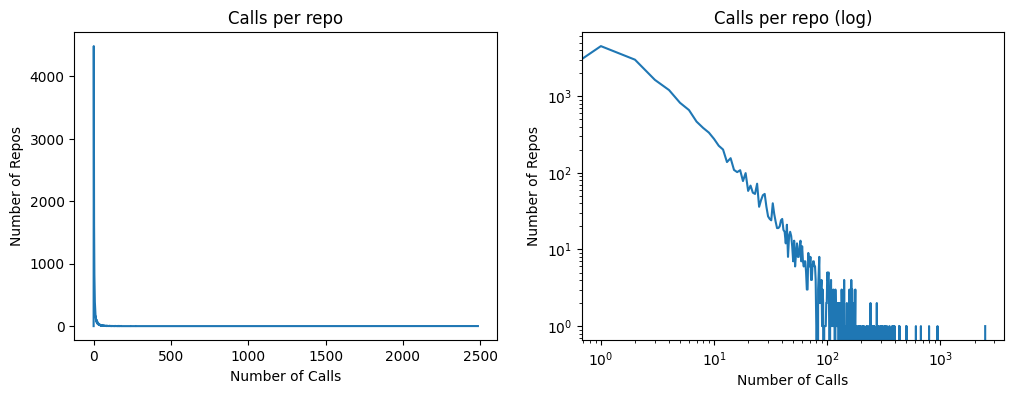

In [3]:
# What is the distribution of number of calls per repo

counter = dict()
for i, row in df.iterrows():
    counter[(row["owner"], row["repo"])] = counter.get((row["owner"], row["repo"]), 0) + 1

maxcount = max(list(counter.values()))
for repo in counter:
    if counter[repo] == maxcount:
        print(repo, maxcount)

count_dist = [0] * (maxcount+1)

for v in counter.values():
    count_dist[v] += 1

# plot

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.set_title("Calls per repo")
ax.set_xlabel("Number of Calls")
ax.set_ylabel("Number of Repos")
ax.plot(range(maxcount+1), count_dist)

ax = fig.add_subplot(122)
ax.set_title("Calls per repo (log)")
ax.set_xlabel("Number of Calls")
ax.set_ylabel("Number of Repos")
ax.plot(range(maxcount+1), count_dist)
ax.set_xscale('log')
ax.set_yscale('log')

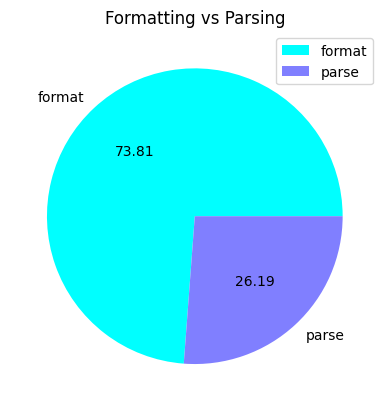

In [4]:
# What is the distribution of operations
categories, counts = np.unique(df["operation"], return_counts=True)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Formatting vs Parsing")
colors = get_even_colors("cool", len(categories))
ax.pie(x=counts, labels=categories, colors = colors, autopct="%.4g")
ax.legend()

0

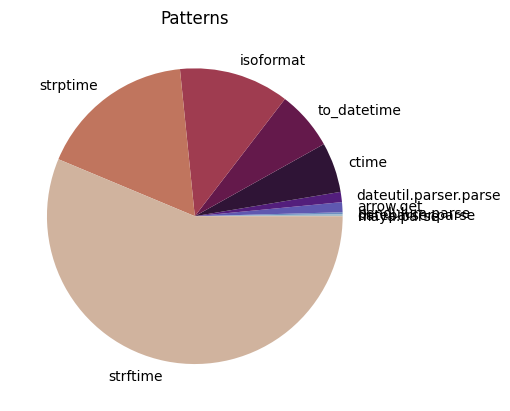

In [5]:
# What is the distribution of patterns
categories, counts = np.unique(df["pattern"], return_counts=True)
counts, categories = zip(*sorted(list(zip(counts, categories))))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Patterns")
colors = get_even_colors("twilight", len(categories))
ax.pie(x=counts, labels=categories, colors = colors)
0
# ax.legend(loc="upper right")

## Finding common string formats
For now I'm only going to consider the following patterns:
 * `strftime` (datetime and time)
 * `strptime` (datetime and time)
 * `ctime`
 * `isoformat`
 
These make up around 90% of the table, and make up basically all of the patterns that use formats (i.e. aren't format agnostic parsers).

In [6]:
filtered_df = df[df["pattern"].isin(["strftime", "strptime", "ctime", "isoformat"])]
print(len(filtered_df) / len(df))

0.909108279318606


In [50]:
# first, strftime formats because they're easiest to parse
pattern = "strftime\\(\\s*[\"\'](.*?)[\"\']\\s*\\)"
print(pattern)
strf_counts = dict()
for i,row in df.iterrows():
    if row["pattern"] == "strftime":
        match = re.search(pattern, row["text"])
        if match is not None:
            strf_counts[match.group(1)] = strf_counts.get(match.group(1), 0) + 1

sorted_strf_counts = sorted(list(zip(strf_counts.values(), strf_counts.keys())), reverse=True)
for i in range(10):
    print(sorted_strf_counts[i])

strftime\(\s*["'](.*?)["']\s*\)
(6541, '%Y-%m-%d')
(6427, '%Y-%m-%d %H:%M:%S')
(2375, '%Y%m%d')
(1592, '%Y%m%d-%H%M%S')
(1553, '%H:%M:%S')
(1105, '%Y-%m-%dT%H:%M:%S')
(1052, '%Y%m%d%H%M%S')
(1023, '%Y')
(828, '%Y-%m-%d_%H-%M-%S')
(763, '%Y-%m-%d-%H-%M-%S')


In [38]:
# strptime should be the same with a slightly longer regex
pattern = "strptime\\(.*?,\\s*[\"\'](.*?)[\"\']\\s*\\)"
print(pattern)
strp_counts = dict()
for i,row in df.iterrows():
    if row["pattern"] == "strptime":
        match = re.search(pattern, row["text"])
        if match is not None:
            strp_counts[match.group(1)] = strp_counts.get(match.group(1), 0) + 1

sorted_strp_counts = sorted(list(zip(strp_counts.values(), strp_counts.keys())), reverse=True)
for i in range(10):
    print(sorted_strp_counts[i])

strptime\(.*?,\s*["'](.*?)["']\s*\)
(3430, '%Y-%m-%d')
(1830, '%Y-%m-%d %H:%M:%S')
(633, '%Y%m%d')
(614, '%Y-%m-%dT%H:%M:%S')
(571, '%Y-%m-%dT%H:%M:%SZ')
(387, '%Y-%m-%d %H:%M:%S.%f')
(344, '%Y-%m-%dT%H:%M:%S.%fZ')
(305, '%H:%M')
(293, '%H:%M:%S')
(271, '%d/%m/%Y')


In [40]:
# how ISO compliant are these format strings?
# It's weirdly hard to find a summary of ISO 8601 online or even a full version that doesn't cost >$100
# this is what I'm going off of https://www.w3.org/TR/NOTE-datetime
# as far as I can tell, python's built in formatter has no way to represent non-utc timezones in iso format, which is kinda weird.
# I'm also allowing spaces in place of the T because most parsers accept that as ISO compliant
def is_iso(fmt):
    components = ["%Y", "-%m", "-%d", "[T ]", "%H", ":%M", ":%S", "\\.%f"]
    for component in components:
        match = re.match(component, fmt)
        if match is None:
            return False
        else:
            fmt = fmt[match.end():]
        
        if fmt == "" or fmt == "Z":
            return True
    return False
    
assert is_iso("%Y-%m-%d %H")
assert not is_iso("%Y-%m-%d %H%M%S")
assert not is_iso("%Y-%m-%d %H:%")
assert not is_iso("%Y-%m-%d %H:%M:%S.%fffffffffff")

''

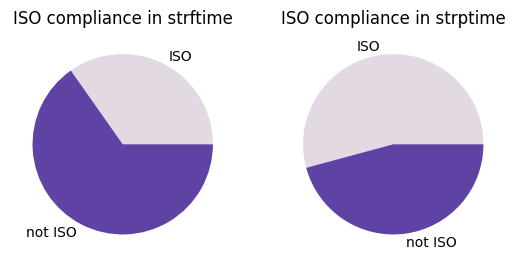

In [48]:
strf_non_iso_count = 0
strf_iso_count = 0
for (count,fmt) in sorted_strf_counts:
    if is_iso(fmt):
        strf_iso_count += count
    else:
        strf_non_iso_count += count

strp_non_iso_count = 0
strp_iso_count = 0
for (count,fmt) in sorted_strp_counts:
    if is_iso(fmt):
        strp_iso_count += count
    else:
        strp_non_iso_count += count

fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_title("ISO compliance in strftime")
colors = get_even_colors("twilight", 3)
ax.pie(x=[strf_iso_count, strf_non_iso_count], labels=["ISO", "not ISO"], colors = colors)

ax = fig.add_subplot(122)
ax.set_title("ISO compliance in strptime")
colors = get_even_colors("twilight", 3)
ax.pie(x=[strp_iso_count, strp_non_iso_count], labels=["ISO", "not ISO"], colors = colors)

""